In [ ]:
!pip install scipy pandas scikit-learn

import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
OU_RAW_PATH = "/content/drive/MyDrive/ML_For_TimeSeries/ou_process_simulation.csv"
DOUBLEWELL_PATH = "/content/drive/MyDrive/ML_For_TimeSeries/DoubleWell_moments.csv"
CIR_PATH        = "/content/drive/MyDrive/ML_For_TimeSeries/cir_process_simulations.csv"
DT_OU = 0.01

In [ ]:
def compute_moments_from_raw_csv(path, dt=0.01):
    """
    path: CSV with shape [T, 1+N_sims]
          col0 is a constant (e.g., 0.5) and is ignored,
          cols 1..N are simulation trajectories.

    Returns:
        DataFrame with columns: time, mean, variance, skewness, kurtosis
    """
    df = pd.read_csv(path, header=None)

    # drop constant column 0
    X = df.iloc[:, 1:].values  # [T, num_sims]

    T = X.shape[0]
    time = np.arange(T) * dt

    moments = pd.DataFrame({
        "time":     time,
        "mean":     X.mean(axis=1),
        "variance": X.var(axis=1, ddof=0),
        "skewness": skew(X, axis=1, bias=True),
        "kurtosis": kurtosis(X, axis=1, fisher=False),
    })
    return moments

In [ ]:
def schatten_Lk_normalize(moment_df, moment_cols, moment_orders, train_frac=0.7, eps=1e-8):
    """
    Normalize each moment m_k(t) by its L_k norm over the train portion:
        ||m_k||_k = (sum_t |m_k(t)|^k)^(1/k)
    moment_cols: ["mean", "variance", "skewness", "kurtosis", ...]
    moment_orders: corresponding moment orders [1,2,3,4,...]
    """
    T = len(moment_df)
    T_train = int(train_frac * T)

    norms = {}
    normed = moment_df.copy()

    for col, k in zip(moment_cols, moment_orders):
        v = normed[col].values.astype(float)
        train_v = v[:T_train]
        Lk = np.power(np.sum(np.abs(train_v) ** k), 1.0 / k)
        if Lk < eps:
            Lk = 1.0
        norms[col] = Lk
        normed[col] = v / Lk

    return normed, norms

In [ ]:
def fit_var2_ridge(M_norm, ridge_alpha=1e-2, train_frac=0.7):
    """
    M_norm: [T, k] normalized moments (no time column)
    Fits VAR(2) with Ridge on 1-step prediction using only the train segment.

    Returns:
        A   : [k, 2k] matrix (A1 | A2)
        T_train : index where train segment ends (in time)
    """
    T, k = M_norm.shape
    T_train = int(train_frac * T)

    X_train = []
    Y_train = []

    # 1-step mapping: m_{t+1} from [m_t, m_{t-1}]
    for t in range(1, T_train - 1):
        feat = np.concatenate([M_norm[t], M_norm[t - 1]])  # [2k]
        targ = M_norm[t + 1]                               # [k]
        X_train.append(feat)
        Y_train.append(targ)

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)

    model = Ridge(alpha=ridge_alpha, fit_intercept=False)
    model.fit(X_train, Y_train)

    # A is model.coef_: [k, 2k]
    A = model.coef_
    return A, T_train


In [ ]:
def recursive_forecast_var2(M_norm, A, T_train):
    """
    Recursive closed-loop forecast on the *test* segment.

    M_norm : [T, k] normalized moments
    A      : [k, 2k]
    T_train: index where training ends

    Returns:
        preds_norm: [T_test-1, k] normalized predictions for times
                    T_train+1 .. T-1
    """
    T, k = M_norm.shape
    T_test = T - T_train

    if T_test <= 1:
        return np.empty((0, k))

    preds = []

    # initial previous and current states
    m_prev = M_norm[T_train - 1]
    m_curr = M_norm[T_train]

    for t in range(T_train, T - 1):
        feat = np.concatenate([m_curr, m_prev])  # [2k]
        y_pred = A @ feat                        # [k]
        preds.append(y_pred)

        m_prev, m_curr = m_curr, y_pred

    return np.array(preds)  # [T_test - 1, k]


In [ ]:
def compute_multi_horizon_metrics(M_true, preds, T_train, horizons=(1, 5, 10)):
    """
    M_true: [T, k] unnormalized true moments
    preds : [L, k] predictions for times T_train+1..T-1
            where L = T - T_train - 1
    T_train: split index
    Returns:
        DataFrame with MSE, RMSE, NRMSE per horizon.
    """
    T, k = M_true.shape
    L = preds.shape[0]   # = T - T_train - 1

    results = []

    for h in horizons:
        max_i = L - (h - 1)
        if max_i <= 0:
            continue

        Y_true = []
        Y_hat = []

        for i in range(max_i):
            t_target = T_train + 1 + i + (h - 1)
            if t_target >= T:
                break
            Y_true.append(M_true[t_target])
            Y_hat.append(preds[i])

        Y_true = np.array(Y_true)
        Y_hat = np.array(Y_hat)

        if len(Y_true) == 0:
            continue

        mse = ((Y_true - Y_hat) ** 2).mean()
        rmse = np.sqrt(mse)
        std_true = Y_true.std()
        nrmse = rmse / (std_true + 1e-8)

        results.append({"horizon": h, "MSE": mse, "RMSE": rmse, "NRMSE": nrmse})

    return pd.DataFrame(results)


In [ ]:
def run_var_baseline(name, df_moments, train_frac=0.7):
    """
    df_moments: DataFrame with columns:
        time, mean, variance, skewness, kurtosis
    """
    print(f"\n===== {name} =====")

    moment_cols   = ["mean", "variance", "skewness", "kurtosis"]
    moment_orders = [1, 2, 3, 4]

    # Normalize
    norm_df, norms = schatten_Lk_normalize(
        df_moments, moment_cols, moment_orders
    )

    M_norm = norm_df[moment_cols].values
    M_true = df_moments[moment_cols].values

    # Fit VAR(2)
    A, T_train = fit_var2_ridge(M_norm)

    # Recursive forecast (normalized)
    preds_norm = recursive_forecast_var2(M_norm, A, T_train)

    # Unnormalize predictions
    preds_true = np.zeros_like(preds_norm)
    for j, col in enumerate(moment_cols):
        preds_true[:, j] = preds_norm[:, j] * norms[col]

    # Evaluate
    metrics_df = compute_multi_horizon_metrics(M_true, preds_true, T_train)
    print(metrics_df)

    # Quick plots (mean + variance, 1-step)
    if preds_true.shape[0] > 0:
        T = len(df_moments)
        L = preds_true.shape[0]
        idx_true = np.arange(T_train + 1, T_train + 1 + L)
        time = df_moments["time"].values

        # Mean
        plt.figure()
        plt.title(f"{name}: mean (1-step)")
        plt.plot(time[idx_true], M_true[idx_true, 0], label="true")
        plt.plot(time[idx_true], preds_true[:, 0], '--', label="pred")
        plt.legend()
        plt.show()

        # Variance
        plt.figure()
        plt.title(f"{name}: variance (1-step)")
        plt.plot(time[idx_true], M_true[idx_true, 1], label="true")
        plt.plot(time[idx_true], preds_true[:, 1], '--', label="pred")
        plt.legend()
        plt.show()

    return metrics_df

In [ ]:
def add_time_column(df, dt=0.01):
    """
    Ensure df has 'time' as the FIRST column.
    If missing, create time = dt * row_index.
    """
    df = df.copy()
    T = len(df)
    time = np.arange(T) * dt

    # Insert time at column 0
    df.insert(0, "time", time)
    return df

In [ ]:
ou_df = compute_moments_from_raw_csv(OU_RAW_PATH, dt=DT_OU)
#dw_df  = pd.read_csv(DOUBLEWELL_PATH)
cir_df = pd.read_csv(CIR_PATH)

dw_df = pd.read_csv(DOUBLEWELL_PATH)
dw_df.columns = ["mean", "variance", "skewness", "kurtosis"]
dw_df = add_time_column(dw_df, dt=0.01)

# CIR moments (drop bad first row, then same idea)
cir_df = pd.read_csv(CIR_PATH, header=None)
cir_df = cir_df.iloc[1:].reset_index(drop=True)

# CIR has extra moment columns → keep only the first 4
cir_df = cir_df.iloc[:, :4]  # keep columns 0,1,2,3

# Name them correctly
cir_df.columns = ["mean", "variance", "skewness", "kurtosis"]

# Add synthetic time column
cir_df = add_time_column(cir_df, dt=0.01)

print(ou_df.head())
print(dw_df.head())
print(cir_df.head())

   time        mean      variance  skewness  kurtosis
0  0.00  500.500000  83333.250000  0.000000  1.799998
1  0.01   -0.075406      0.052476  0.234838  2.955033
2  0.02   -0.208831      0.139164 -0.088539  2.272067
3  0.03    0.148473      0.043819 -0.117597  2.535928
4  0.04    0.093399      0.097775 -0.630382  2.596947
   time      mean  variance  skewness  kurtosis
0  0.00 -0.000293  0.006726  0.000781 -0.000385
1  0.01 -0.000299  0.006451  0.000656 -0.001636
2  0.02 -0.000302  0.006248  0.000582 -0.002599
3  0.03 -0.000305  0.006080  0.000539 -0.003328
4  0.04 -0.000296  0.005922  0.000550 -0.003963
   time      mean  variance  skewness  kurtosis
0  0.00  0.040000  0.040031  0.040063  0.040094
1  0.01  0.040003  0.040065  0.040128  0.040190
2  0.02  0.040009  0.040103  0.040197  0.040290
3  0.03  0.040011  0.040136  0.040261  0.040385
4  0.04  0.040009  0.040165  0.040321  0.040477



===== OU =====
   horizon       MSE      RMSE     NRMSE
0        1  0.175080  0.418425  0.341640
1        5  0.156578  0.395700  0.323764
2       10  0.162706  0.403368  0.322481


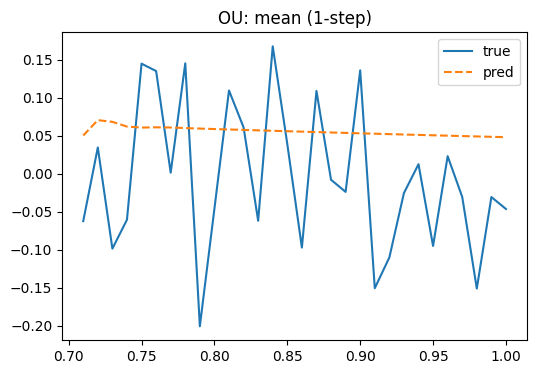

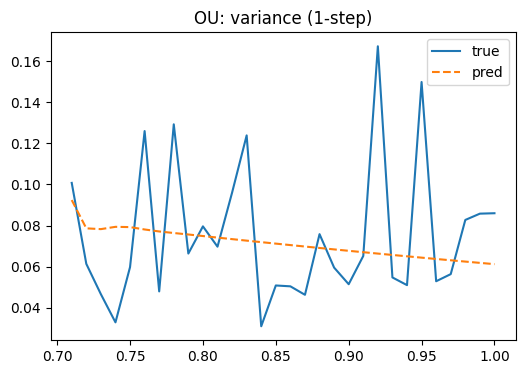


===== Double-well =====
   horizon           MSE      RMSE     NRMSE
0        1  5.114146e-08  0.000226  0.032512
1        5  5.087118e-08  0.000226  0.032426
2       10  5.053416e-08  0.000225  0.032319


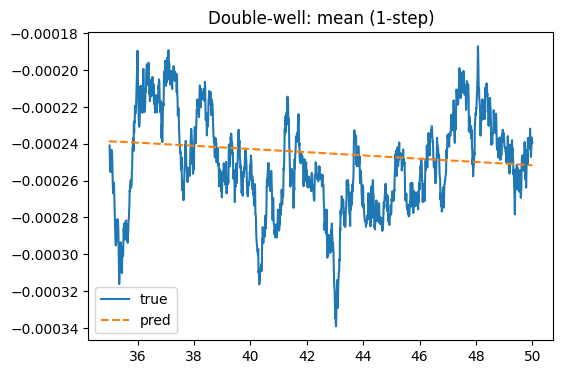

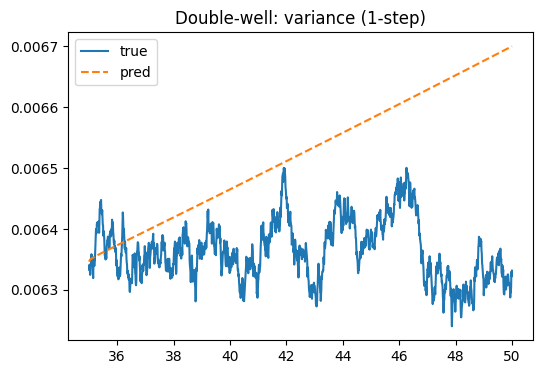


===== CIR =====
   horizon       MSE      RMSE     NRMSE
0        1  0.000035  0.005881  0.624877
1        5  0.000034  0.005826  0.618793
2       10  0.000033  0.005758  0.611211


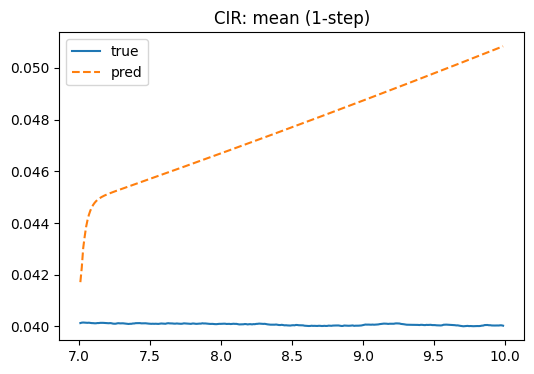

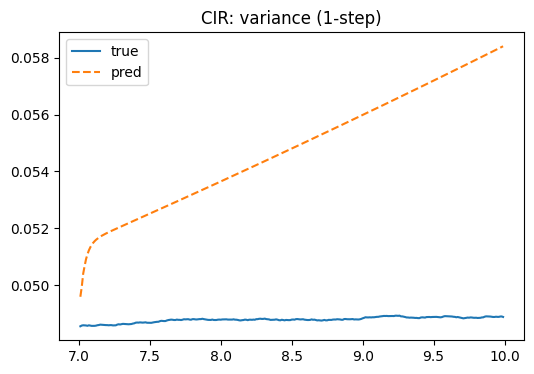


===== SUMMARY =====


,horizon,MSE,RMSE,NRMSE,dataset
0,1,1.750795e-01,0.418425,0.341640,OU
1,5,1.565784e-01,0.395700,0.323764,OU
2,10,1.627056e-01,0.403368,0.322481,OU
0,1,5.114146e-08,0.000226,0.032512,Double-well
1,5,5.087118e-08,0.000226,0.032426,Double-well
2,10,5.053416e-08,0.000225,0.032319,Double-well
0,1,3.458407e-05,0.005881,0.624877,CIR
1,5,3.394535e-05,0.005826,0.618793,CIR
2,10,3.315902e-05,0.005758,0.611211,CIR


In [ ]:
metrics_ou = run_var_baseline("OU", ou_df)
metrics_dw = run_var_baseline("Double-well", dw_df)
metrics_cir = run_var_baseline("CIR", cir_df)

summary = pd.concat([
    metrics_ou.assign(dataset="OU"),
    metrics_dw.assign(dataset="Double-well"),
    metrics_cir.assign(dataset="CIR"),
])

print("\n===== SUMMARY =====")
summary